In [23]:
import glob
import os

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray as cfxr
import rioxarray as rxr

import xcdat as xc
import xesmf as xe

from cartopy import crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import colormaps as cmo 

import numpy as np
import scipy as sc
import pandas as pd
import geopandas as gpd
import regionmask

from rich import print as rprint
from tqdm.notebook import tqdm
%load_ext rich

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [24]:
west = 106.2
east = 107.15
north = -5.1
south = -6.2

# west = 106.3640
# east = 107.1060
# north = -5.1350
# south = -6.1810

extent = [west, east, south, north]

In [25]:
demnas = xr.open_dataset('/home/edskywalker/Documents/Resources/Masks/MODISLandWater/MOD44W_Indonesia.nc', decode_coords="all")

demnas_lonlat = demnas.rio.reproject("EPSG:4326")

demnas_clip = demnas_lonlat.rio.clip_box(
    minx=west,
    miny=south,
    maxx=east,
    maxy=north,
    crs= "EPSG:4326",
)

display(demnas_clip)


<xarray.Dataset> Size: 6MB
Dimensions:        (x: 451, y: 522, band: 1)
Coordinates:
  * x              (x) float64 4kB 106.2 106.2 106.2 106.2 ... 107.1 107.1 107.1
  * y              (y) float64 4kB -5.099 -5.102 -5.104 ... -6.195 -6.197 -6.199
  * band           (band) int64 8B 1
    spatial_ref    int64 8B 0
Data variables:
    water_mask     (band, y, x) float64 2MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    seven_class    (band, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    water_mask_QA  (band, y, x) float64 2MB 4.0 4.0 4.0 4.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/52)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:      MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:        Terra
    ASSOCIATEDSENSORSHORTNAME.1:          MODIS
    AUTOMATICQUALITYFLAG.1:               Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:    set passed as default, will decide ...
    DATACOLUMNS:                          4800
    ...                                   ...
    SOUTHBOUNDINGCOORDINATE:              0.0
    SPSOPARAMETERS:                       none
    TileID:                               51027008
    VERSIONID:                            61
    VERTICALTILENUMBER:                   8
    WESTBOUNDINGCOORDINATE:               89.9999999919177

In [26]:
darat = xr.where((demnas_clip['water_mask_QA'] == 4), np.nan, demnas_clip['water_mask_QA'])

mask = xr.Dataset()

mask['mask'] = darat.where(~np.isfinite(darat), 1) * 0
mask = mask.fillna(1)
mask = mask.rename({'x':'lon', 'y':'lat'})
mask = mask.squeeze(dim="band").reset_coords(["spatial_ref","band"], drop=True).astype(int)

display(mask)

<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 522, lon: 451)
Coordinates:
  * lon      (lon) float64 4kB 106.2 106.2 106.2 106.2 ... 107.1 107.1 107.1
  * lat      (lat) float64 4kB -5.099 -5.102 -5.104 ... -6.195 -6.197 -6.199
Data variables:
    mask     (lat, lon) int64 2MB 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0

In [27]:
num_oce = np.sum(mask['mask'] == 1)

comp_land = dict(zlib=True, complevel=4)
mask_enc = {var: comp_land for var in mask.data_vars}

if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/land_mask.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/land_mask.nc')

mask.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/land_mask.nc',
    encoding = mask_enc)

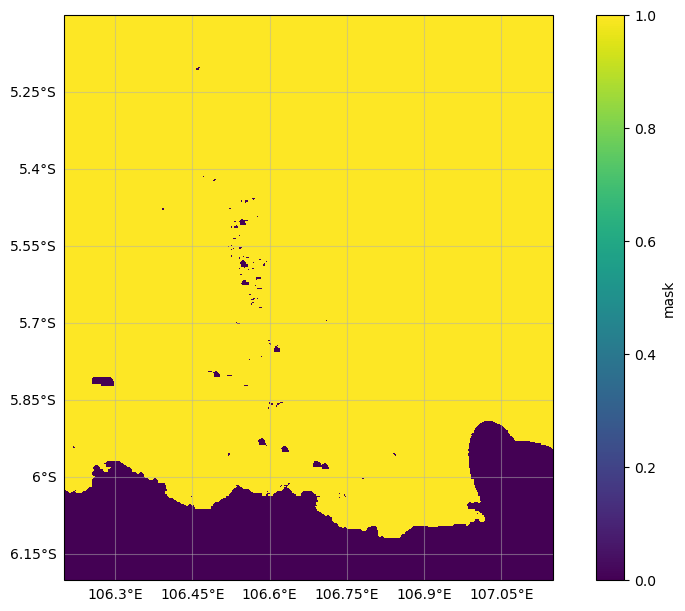

In [28]:
fig, ax = plt.subplots(figsize=[10,6], layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

ax.set_extent(extent, crs=ccrs.PlateCarree())

ini = ax.gridlines(draw_labels = True, alpha=0.5)
ini.top_labels = False
ini.right_labels = False

mask.mask.plot(ax=ax, transform=ccrs.PlateCarree())

In [29]:
chl_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc')
# chl_exported = chl_exported.sel(lon=slice(west,east),lat=slice(north,south))
# chl_exported = chl_exported.ffill(dim='lon', limit=5)

rprint(chl_exported)

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 1158, lon: 451, lat: 522)
Coordinates:
  * time     (time) datetime64[ns] 9kB 2017-11-07T02:53:03.994778 ... 2023-12...
  * lon      (lon) float64 4kB 106.2 106.2 106.2 106.2 ... 107.1 107.1 107.1
  * lat      (lat) float64 4kB -5.099 -5.102 -5.104 ... -6.195 -6.197 -6.199
Data variables:
    chl_nn   (time, lat, lon) float32 1GB ...
    chl_oc   (time, lat, lon) float32 1GB ...
    tsm_nn   (time, lat, lon) float32 1GB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 19 18:46:22 2024: cdo -O -s -f nc -mergetime /mnt/d...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [33]:
chl_nn_res = chl_exported['chl_nn'].resample(time='SMS').mean(dim='time')
#chl_nn_res = chl_nn_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

chl_oc_res = chl_exported['chl_oc'].resample(time='SMS').mean(dim='time')
#chl_oc_res = chl_oc_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

tsm_nn_res = chl_exported['tsm_nn'].resample(time='SMS').mean(dim='time')
#tsm_nn_res = tsm_nn_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))


In [35]:
chl_resampled = [chl_nn_res,chl_oc_res,tsm_nn_res]

for lists in chl_resampled:
    if os.path.exists(f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc'):
        os.remove(f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc')

    lists.to_netcdf(
        f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc',
        format = 'NETCDF4',
        unlimited_dims = 'time',
        encoding = {f"{lists.name}": {'zlib':True, 'complevel':4, '_FillValue':-9999.0}} # {var: comp for var in ref_resampled.data_vars}
        )

In [36]:
ref_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc')
# ref_exported = ref_exported.sel(lon=slice(west,east),lat=slice(south,north))
# ref_exported = ref_exported.ffill(dim='lon', limit=5)

rprint(ref_exported)

<xarray.Dataset> Size: 13GB
Dimensions:  (time: 1932, lon: 451, lat: 522)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2017-11-03T02:56:48.405115 ... 2023-1...
  * lon      (lon) float64 4kB 106.2 106.2 106.2 106.2 ... 107.1 107.1 107.1
  * lat      (lat) float64 4kB -5.099 -5.102 -5.104 ... -6.195 -6.197 -6.199
Data variables:
    Oa06     (time, lat, lon) float32 2GB ...
    Oa07     (time, lat, lon) float32 2GB ...
    Oa08     (time, lat, lon) float32 2GB ...
    Oa09     (time, lat, lon) float32 2GB ...
    Oa10     (time, lat, lon) float32 2GB ...
    Oa11     (time, lat, lon) float32 2GB ...
    Oa12     (time, lat, lon) float32 2GB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 19 19:25:55 2024: cdo -O -s -f nc -remapcon,/home/e...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [38]:
ref_06_res = ref_exported['Oa06'].resample(time='SMS').mean(dim='time')
#ref_06_res = ref_06_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_07_res = ref_exported['Oa07'].resample(time='SMS').mean(dim='time')
#ref_07_res = ref_07_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_08_res = ref_exported['Oa08'].resample(time='SMS').mean(dim='time')
#ref_08_res = ref_08_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_09_res = ref_exported['Oa09'].resample(time='SMS').mean(dim='time')
#ref_09_res = ref_09_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_10_res = ref_exported['Oa10'].resample(time='SMS').mean(dim='time')
#ref_10_res = ref_10_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_11_res = ref_exported['Oa11'].resample(time='SMS').mean(dim='time')
#ref_11_res = ref_11_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

ref_12_res = ref_exported['Oa12'].resample(time='SMS').mean(dim='time')
#ref_12_res = ref_12_res.where(mask['mask'] == 1).dropna(dim='time', how='any', thresh=int(0.2*num_oce))

#rprint(len(ref_06_res.time), len(ref_07_res.time), len(ref_08_res.time), len(ref_09_res.time), len(ref_10_res.time), len(ref_11_res.time), len(ref_12_res.time))

In [39]:
ref_resampled = [ref_06_res,ref_07_res,ref_08_res,ref_09_res,ref_10_res,ref_11_res,ref_12_res]

for lists in ref_resampled:
    if os.path.exists(f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc'):
        os.remove(f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc')

    lists.to_netcdf(
        f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}.nc',
        format = 'NETCDF4',
        unlimited_dims = 'time',
        encoding = {f"{lists.name}": {'zlib':True, 'complevel':4, '_FillValue':-9999.0}} # {var: comp for var in ref_resampled.data_vars}
        )

In [40]:
chlnn = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_nn.nc')['chl_nn']
chlnn = 10 ** chlnn

Oa06 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa06.nc')['Oa06']
Oa08 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa08.nc')['Oa08']
Oa12 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa12.nc')['Oa12']

rdi = ((1 / Oa08) - (1 / Oa06)) * Oa12


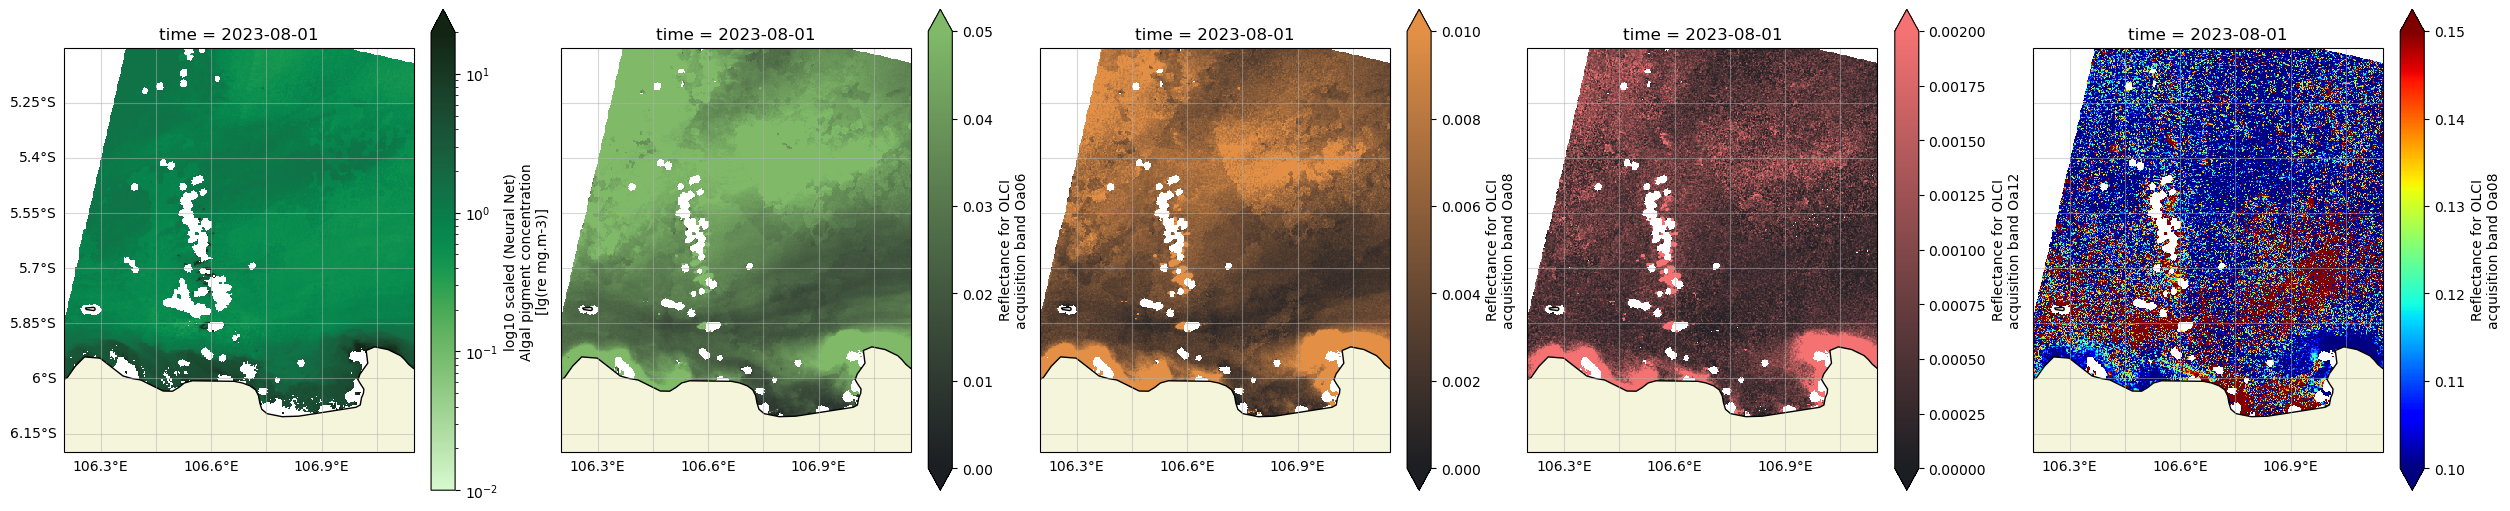

In [41]:
fig, ax = plt.subplots(figsize=[25,5], ncols=5, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(5):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels = False

chlnn.sel(time='2023-08-01').plot(ax=ax[0], norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())
Oa06.sel(time='2023-08-01').plot(ax=ax[1], norm=colors.Normalize(0,0.05), cmap=cmo.greens_light, zorder=0, transform=ccrs.PlateCarree())
Oa08.sel(time='2023-08-01').plot(ax=ax[2], norm=colors.Normalize(0,0.01), cmap=cmo.oranges_light, zorder=0, transform=ccrs.PlateCarree())
Oa12.sel(time='2023-08-01').plot(ax=ax[3], norm=colors.Normalize(0,0.002), cmap=cmo.reds_light, zorder=0, transform=ccrs.PlateCarree())

rdi.sel(time='2023-08-01').plot(ax=ax[4], norm=colors.Normalize(0.10,0.15), cmap='jet', zorder=0, transform=ccrs.PlateCarree())
